<a href="https://colab.research.google.com/github/stochasticats/imdb-review-sentiment-classifier/blob/master/imdb_movie_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDb Movie Review Sentiment Classification
This Google colab notebook is for developing a deep learning model to classify movie reviews as positive or negative using the data set provided here http://ai.stanford.edu/~amaas/data/sentiment/

First we establish the libraries to be used.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
import os
import shutil
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2.2.0


We download the zipped data from ai.stanford

In [2]:
!wget "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

--2020-06-01 04:53:15--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  19.5MB/s    in 6.7s    

2020-06-01 04:53:22 (12.0 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
%%capture
!tar -xvf "/content/aclImdb_v1.tar.gz"

Here I establish stopwords, these are words that will add no meaning to the reviews

In [0]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

Let's load the training data, which is conveniently in two folders based on the sentiment classification.

In [0]:
loc = '/content/aclImdb/train/pos'
os.chdir(loc)
filelist = os.listdir()

reviews_pos = []
labels_pos = []

for f in filelist:
  with open (f, "r") as myfile:
    labels_pos.append(1)
    review = myfile.read()
    for word in stopwords:
            token = " " + word + " "
            review = review.replace(token, " ")
            review = review.replace("  ", " ")
    reviews_pos.append(review)

loc = '/content/aclImdb/train/neg'
os.chdir(loc)
filelist = os.listdir()

reviews_neg = []
labels_neg = []

for f in filelist:
  with open (f, "r") as myfile:
    labels_neg.append(0)
    review = myfile.read()
    for word in stopwords:
            token = " " + word + " "
            review = review.replace(token, " ")
            review = review.replace("  ", " ")
    reviews_neg.append(review)

In [6]:
randn = random.randint(0,len(reviews_pos))

print("Length of reviews that are positive:")
print(len(reviews_pos))
print("Example of a positive review:")
print(reviews_pos[randn])
print("The label:")
print(labels_pos[randn])
print("Length of reviews that are positive:")
print(len(reviews_neg))
print("Example of a negative review:")
print(reviews_neg[randn])
print("The label:")
print(labels_neg[randn])

Length of reviews that are positive:
12500
Example of a positive review:
I watched July even Christmas theme, found touching sensitive. It not someone reality-mind full fantasy lovely moments sometimes don't make sense. William Russ grand job Hank. I seen remake The Long, Hot Summer played weak character. But one, expression eyes throughout, Hank considered things happening him, wonderful tender. Valerie Bertinelli excellent lovely usual believable role. And Peter Falk Max splendid always brought smile appeared number important scenes. There many special scenes, including one Hank realizes Max really life. It's not everyone.....especially aren't 'feel-good' movies definitely one! If like everything perfect make sense, avoid one. But I think well-worth re-watching, I taped it. (Yes, us still VCRs. :)
The label:
1
Length of reviews that are positive:
12500
Example of a negative review:
This movie bad, can compared all-time worst "comedy": Police Academy 7. No laughs throughout movie. Do 

We have 25,000 reviews in total, 12,500 positive and 12,500 negative. As we can see, our reviews need some processing for the deep learning model.  We need to take out the digits and special characters.

Here's a function to use to process the data.

In [0]:
import spacy
import re,string,unicodedata

def preprocess(text):
    text = re.sub('<[^>]*>', '',text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text=re.sub('[\W]+',' ',text.lower()) +\
       ' '.join(emoticons).replace('-','')  
    return text

In [0]:
reviews = reviews_pos + reviews_neg
labels = labels_pos + labels_neg

In [0]:
denoised_reviews = []

for review in reviews:
  denoised_reviews.append(preprocess(review))

Let's put it into a single data frame and take a look.

In [0]:
dataframe = pd.DataFrame(
    {'reviews': denoised_reviews,
     'labels': labels,
    })
from sklearn.utils import shuffle
dataframe = shuffle(dataframe).reset_index(drop=True)

In [11]:
dataframe.head(20)

,reviews,labels
0,it s funny it great cast give great performanc...,1
1,the problem family dramas that outside tv movi...,0
2,ah spirit 68 the streets paris running wild re...,0
3,soylent green classic i waiting someone re do ...,1
4,i opportunity see film debut appalachian film ...,1
5,i don t understand not critic not evaluating q...,1
6,what long drawn out pointless movie i m sure h...,0
7,first off i m not dog movie i find totally enj...,0
8,come undone appears elicit lot opinions among...,1
9,an obvious b grade effort cash hostel saw buzz...,0


Let's take a look at the distribution of review length.

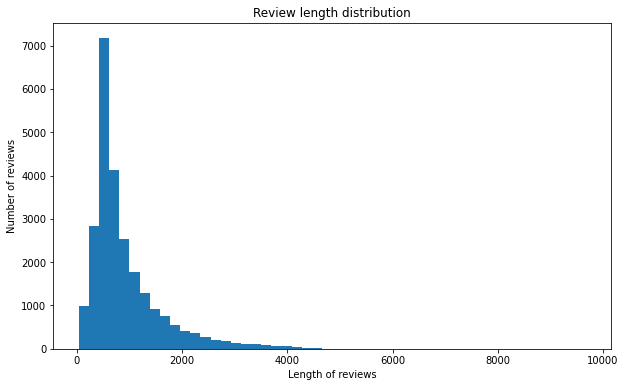

In [12]:
plt.figure(figsize=(10, 6))
plt.hist([len(review) for review in dataframe['reviews']], 50)
plt.xlabel('Length of reviews')
plt.ylabel('Number of reviews')
plt.title('Review length distribution')
plt.show()

There seems to be a peak at around length ~1000, meaning there's a lot of reviews with length ~1000. 

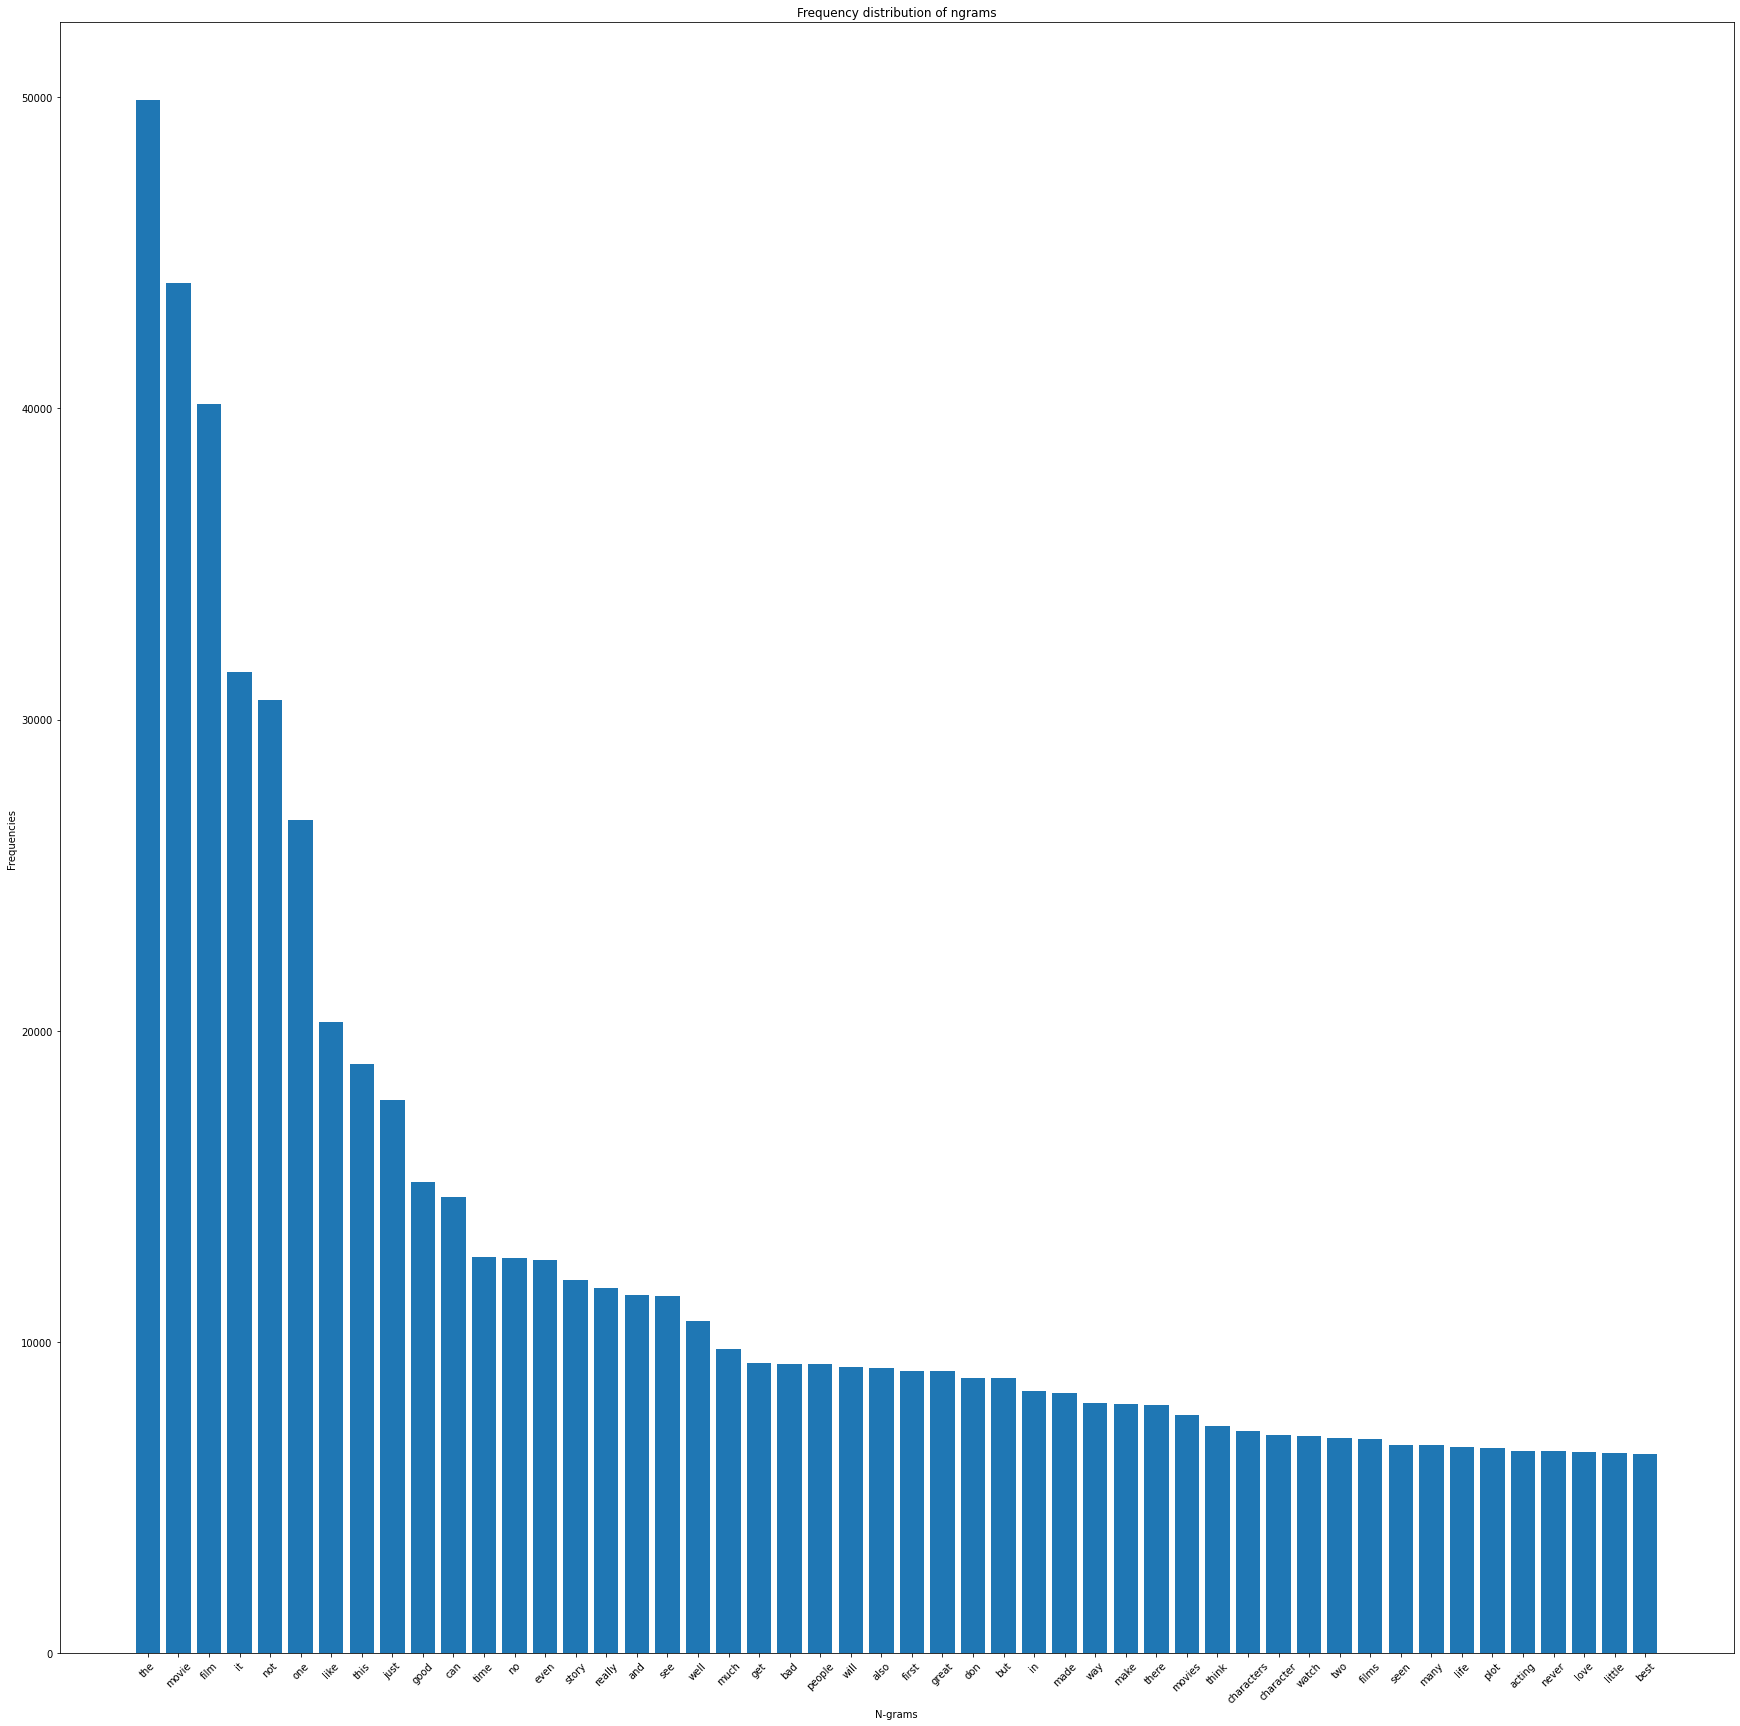

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
# So, we get such structure:
#        | word1  | word2  |  word3 | word4
# text1  |   1    |    1   |   1    |   0
# text2  |   0    |    1   |   1    |   0
# text3  |   2    |    1   |   0    |   0
# text4  |   0    |    0   |   0    |   1
vect_texts = vectorizer.fit_transform(list(dataframe['reviews']))
# ['word1', 'word2', 'word3', 'word4']
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

# Let's now plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

In [0]:
vocab_size = 2500
embedding_dim = 128
max_length = 1500
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(dataframe['reviews'], dataframe['labels'], test_size=0.2, random_state=42)

In [16]:
print(len(X_train))
print(len(y_train))
print(len(X_valid))
print(len(y_valid))

20000
20000
5000
5000


In [17]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train_seqs = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seqs, padding=padding_type, maxlen=max_length)

print(len(X_train_seqs[0]))
print(len(X_train_padded[0]))

print(len(X_train_seqs[600]))
print(len(X_train_padded[600]))

print(len(X_train_seqs[10000]))
print(len(X_train_padded[10000]))

135
1500
215
1500
96
1500


In [18]:
X_valid_seqs = tokenizer.texts_to_sequences(X_valid)
X_valid_padded = pad_sequences(X_valid_seqs, padding=padding_type, maxlen=max_length)

print(len(X_valid_seqs))
print(X_valid_padded.shape)

5000
(5000, 1500)


In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 128)         320000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [39]:
num_epochs = 30
history = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_valid_padded, y_valid), verbose=2)

Epoch 1/30
625/625 - 10s - loss: 0.6987 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5078
Epoch 2/30
625/625 - 10s - loss: 0.6871 - accuracy: 0.5172 - val_loss: 0.4520 - val_accuracy: 0.7940
Epoch 3/30
625/625 - 10s - loss: 0.3553 - accuracy: 0.8539 - val_loss: 0.3253 - val_accuracy: 0.8620
Epoch 4/30
625/625 - 10s - loss: 0.1913 - accuracy: 0.9270 - val_loss: 0.3686 - val_accuracy: 0.8582
Epoch 5/30
625/625 - 10s - loss: 0.0771 - accuracy: 0.9736 - val_loss: 0.5436 - val_accuracy: 0.8528
Epoch 6/30
625/625 - 10s - loss: 0.0299 - accuracy: 0.9902 - val_loss: 0.6787 - val_accuracy: 0.8504
Epoch 7/30
625/625 - 10s - loss: 0.0225 - accuracy: 0.9920 - val_loss: 0.8505 - val_accuracy: 0.8546
Epoch 8/30
625/625 - 10s - loss: 0.0182 - accuracy: 0.9942 - val_loss: 0.9993 - val_accuracy: 0.8516
Epoch 9/30
625/625 - 10s - loss: 0.0157 - accuracy: 0.9951 - val_loss: 1.0413 - val_accuracy: 0.8474
Epoch 10/30
625/625 - 10s - loss: 0.0169 - accuracy: 0.9942 - val_loss: 1.1144 - val_accura

KeyboardInterrupt: ignored

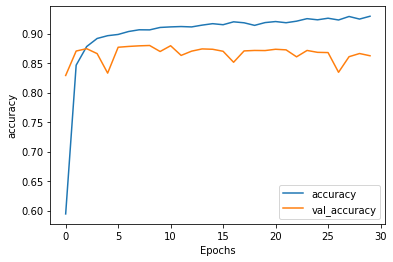

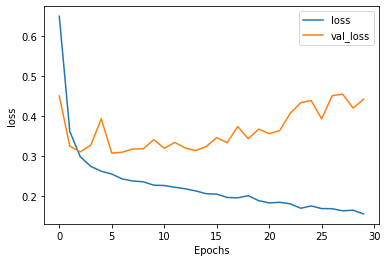

In [21]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
loc = '/content/aclImdb/test/pos'
os.chdir(loc)
filelist = os.listdir()

test_sentences_pos = []
test_labels_pos = []

for f in filelist:
  with open (f, "r") as myfile:
    test_labels_pos.append(1)
    sentence = myfile.read()
    for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
            sentence = sentence.replace("  ", " ")
    test_sentences_pos.append(sentence)

loc = '/content/aclImdb/train/neg'
os.chdir(loc)
filelist = os.listdir()

test_sentences_neg = []
test_labels_neg = []

for f in filelist:
  with open (f, "r") as myfile:
    test_labels_neg.append(0)
    sentence = myfile.read()
    for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
            sentence = sentence.replace("  ", " ")
    test_sentences_neg.append(sentence)

In [0]:
test_sentences = test_sentences_pos + test_sentences_neg
test_labels = test_labels_pos + test_labels_neg

denoised_test_sentences = []

for sentence in test_sentences:
  denoised_test_sentences.append(preprocess(sentence))

dataframe_test = pd.DataFrame(
    {'sentences': denoised_test_sentences,
     'labels': test_labels,
    })

In [0]:
dataframe_test = shuffle(dataframe_test).reset_index(drop=True)

In [0]:
test_sentences = dataframe_test['sentences']
test_labels = dataframe_test['labels']

In [0]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [36]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

782/782 [==============================] - 5s 7ms/step - loss: 0.3349 - accuracy: 0.8840
Test loss: 0.3349135220050812
Test accuracy: 0.8839600086212158
